<a href="https://colab.research.google.com/github/geotrush/Neural-Network-Zoo/blob/main/Fast%20Neural%20Style%20Transfer%20with%20MSG-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Neural Style Transfer with MSG-Net
-----------------------------------------
### Paper: [Multi-style Generative Network for Real-time Transfer (Zhang and Dana., 2017)](https://arxiv.org/pdf/1703.06953.pdf)

### Repo: [PyTorch Implementation of MSG-Net](https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer)

- Import libraries

In [ ]:
# Notebook display
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output

# PyTorch
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.nn import Module, Sequential, Parameter, ReflectionPad2d, InstanceNorm2d, ReLU, Conv2d

- Define constants and image processing functions

In [ ]:
# Image size
SIZE = 1024

# Determine device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-processing
def prep(image, size=SIZE, keep_aspect_ratio=False, to_tensor=False, device=DEVICE):
    if keep_aspect_ratio:
        size2 = int(size / image.size[0] * image.size[1])
        image = image.resize((size, size2), Image.LANCZOS)
    else:
        image = image.resize((size, size), Image.LANCZOS)
    if to_tensor:
        image2tensor = transforms.Compose([transforms.ToTensor(),
                                           transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]),
                                           transforms.Lambda(lambda x: x.mul_(255))])
        return image2tensor(image).unsqueeze(0).to(device)
    else:
        return image

# Post-processing
def post(tensor):
    tensor = tensor.cpu().squeeze(0).clamp_(0, 255)
    tensor2image = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1. / 255)),
                                       transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]),
                                       transforms.ToPILImage()])
    return tensor2image(tensor)

# Draw content, style and output images
def draw(input, content_image, style_image):
    output = post(input)

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(prep(content_image, keep_aspect_ratio=True))
    ax1.axis('off')
    ax1.set_title('Content Image')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(prep(style_image, keep_aspect_ratio=True))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(output)
    ax3.axis('off')
    ax3.set_title('Output Image')

    plt.show()
    return output

- Load content and style images

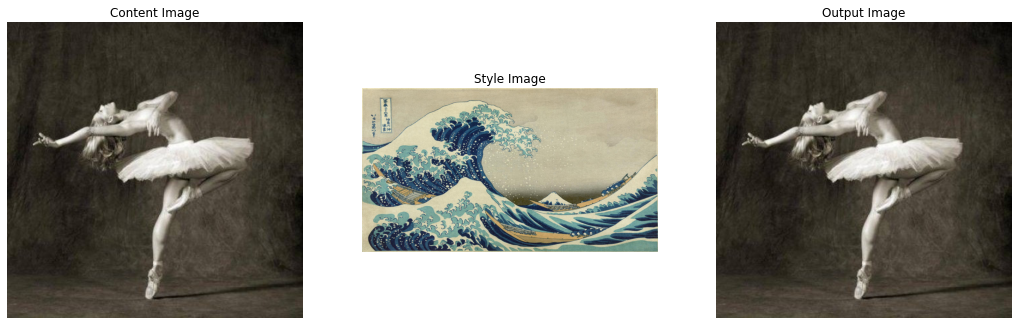

In [ ]:
# Manually upload the images
files.upload()
clear_output()

# Open and prepare images
content_image, style_image = Image.open('ballerina.jpg'), Image.open('wave.jpg')
input, style = prep(content_image, keep_aspect_ratio=True, to_tensor=True), prep(style_image, to_tensor=True)

# Display images
_ = draw(input, content_image, style_image)

- Define MSG-Net with nearest neighbour upsampling instead of transposed convolutions for better performance

In [ ]:
class CoMatchLayer(Module):
    def __init__(self, channels, batch_size=1):
        super().__init__()

        self.C = channels
        self.weight = Parameter(torch.Tensor(1, channels, channels), requires_grad=True)
        self.GM_t = torch.Tensor(batch_size, channels, channels).requires_grad_()

        # Weight Initialization
        self.weight.data.uniform_(0.0, 0.02)

    def set_targets(self, GM_t):
        self.GM_t = GM_t

    def forward(self, x):
        self.P = torch.bmm(self.weight.expand_as(self.GM_t), self.GM_t)
        return torch.bmm(self.P.transpose(1, 2).expand(x.size(0), self.C, self.C), x.view(x.size(0), x.size(1), -1)).view_as(x)


class ConvBlock(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super().__init__()

        if upsample:
            stride = 1
            upsample = 2
        self.upsample = upsample
        self.padding = kernel_size // 2
        self.conv = Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=self.upsample)
        if self.padding:
            x = ReflectionPad2d(self.padding)(x)
        conv = self.conv(x)
        return conv


class ResBlock(Module):

    expansion = 4

    def __init__(self, in_channels, channels, stride=1, downsample=False, upsample=False):
        super().__init__()

        self.downsample = downsample
        self.upsample = upsample

        if downsample:
            self.downsampling_layer = Conv2d(in_channels, channels * self.expansion, kernel_size=1, stride=stride)
        if upsample:
            self.upsampling_layer = ConvBlock(in_channels, channels * self.expansion, kernel_size=1, stride=1, upsample=stride)

        self.conv_block = Sequential(InstanceNorm2d(in_channels), ReLU(),
                                     Conv2d(in_channels, channels, kernel_size=1, stride=1),
                                     InstanceNorm2d(channels), ReLU(),
                                     ConvBlock(channels, channels, kernel_size=3, stride=stride, upsample=self.upsample),
                                     InstanceNorm2d(channels), ReLU(),
                                     Conv2d(channels, channels * self.expansion, kernel_size=1, stride=1))

    def forward(self, x):
        residual = x
        conv = self.conv_block(x)
        if self.downsample:
            residual = self.downsampling_layer(x)
        if self.upsample:
            residual = self.upsampling_layer(x)
        return conv + residual


class MSGNet(Module):
    def __init__(self, in_channels=3, out_channels=3, channels=128, num_res_blocks=6):
        super().__init__()

        self.siamese_network = Sequential(ConvBlock(in_channels, 64, kernel_size=7, stride=1),
                                          InstanceNorm2d(64), ReLU(),
                                          ResBlock(64, 32, stride=2, downsample=True),
                                          ResBlock(32 * ResBlock.expansion, channels, stride=2, downsample=True))

        self.comatch_layer = CoMatchLayer(channels * ResBlock.expansion)

        self.transformation_network = Sequential(self.siamese_network,
                                                 self.comatch_layer,
                                                 *[ResBlock(channels * ResBlock.expansion, channels) for _ in range(num_res_blocks)],
                                                 ResBlock(channels * ResBlock.expansion, 32, stride=2, upsample=True),
                                                 ResBlock(32 * ResBlock.expansion, 16, stride=2, upsample=True),
                                                 InstanceNorm2d(16 * ResBlock.expansion), ReLU(),
                                                 ConvBlock(16 * ResBlock.expansion, out_channels, kernel_size=7, stride=1))

    def gram_matrix(self, inputs):
        BS, C, H, W = inputs.size()
        inputs = inputs.view(BS, C, H * W)
        GM = inputs.bmm(inputs.transpose(1, 2))
        return GM.div_(C * H * W)

    def set_targets(self, x):
        targets = self.siamese_network(x)
        GM_t = self.gram_matrix(targets)
        self.comatch_layer.set_targets(GM_t)

    def forward(self, x):
        return self.transformation_network(x)

- Load MSG-Net weights & biases pretrained on 21 styles


In [ ]:
msgnet = MSGNet().to(DEVICE)

!wget -O msgnet_21styles.model https://www.dropbox.com/s/2iz8orqqubrfrpo/21styles.model?dl=1

state = msgnet.state_dict()
new_state = torch.load('msgnet_21styles.model')
new_state_copy = new_state.copy()

for key, value in new_state_copy.items():
    if key.endswith(('running_mean', 'running_var')):
        del new_state[key]

new_state_values = list(new_state.values())

for i, key in enumerate(state):
    state[key] = new_state_values[i]

msgnet.load_state_dict(state)

- Transfer style

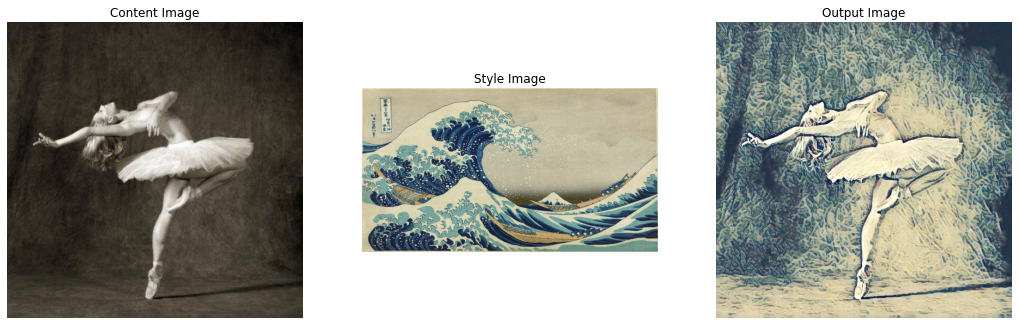

In [ ]:
def transfer_style(msgnet, input):
    msgnet.eval()
    with torch.no_grad():
        output = draw(msgnet(input), content_image, style_image)
    return output

# Pre-compute targets
msgnet.set_targets(style)

# Run
output = transfer_style(msgnet, input)

- Save and download output

In [ ]:
output.save('output.png')
files.download('output.png')